In [1]:
import numpy as np
import pandas as pd
from scipy.stats import halfnorm
from scipy.stats import expon
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib

from sfma.api import SFMAModel

In [51]:
class Simulator:
    def __init__(self, nu: int, gamma: int, sigma_min: float, sigma_max: float,
                 x: callable, func: callable, ineff_dist: str = 'half-normal'):
        """
        Simulation class for stochastic frontier meta-analysis.
        
        nu
            The scale of the inefficiency term
        gamma
            The variance of the random effect term
        sigma_min, sigma_max
            The study-specific errors, max and minimum. They will be drawn from a uniform distribution.
        x
            A callable function to generate a realization from a random variable x (is the covariate used
            to construct the frontier). Needs to have an argument size.
        func
            A function of x that defines the frontier
        ineff_dist
            Inefficiency distribution
        """
        self.nu = nu
        self.gamma = gamma
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.x = x
        self.func = func
        
        if ineff_dist == 'half-normal':
            self.rvs = halfnorm.rvs
        elif ineff_dist == 'exponential':
            self.rvs = expon.rvs
        else:
            raise RuntimeError("Inefficiency distribution must be half-normal or exponential")
    
    def simulate(self, n: int = 1, **kwargs):
        np.random.seed(365)
        sigma = stats.uniform.rvs(loc=self.sigma_min, scale=self.sigma_max, size=n)
        epsilon = stats.norm.rvs(loc=0, scale=sigma, size=n)
        
        us = stats.norm.rvs(loc=0, scale=self.gamma, size=n)
        vs = self.rvs(scale=self.nu, size=n)
        
        xs = self.x(size=n, **kwargs)
        front = self.func(xs)
        observed = front + us - vs + epsilon
        return us, vs, epsilon, sigma, xs, front, observed

In [39]:
np.random.seed(150)

## Figure 1

Data generating process

In [40]:
s = Simulator(nu=1, gamma=0.25, sigma_min=0, sigma_max=0.75, 
              x=lambda size: stats.uniform.rvs(size=size, loc=0.5), func=lambda x: np.log(x) + 10)
us, vs, epsilon, sigma, xs, front, observed = s.simulate(n = 30)

x_front = np.linspace(xs.min(), xs.max())
y_front = s.func(np.linspace(xs.min(), xs.max()))

ymin = observed.min() - 0.5
ymax = observed.max() + 0.5

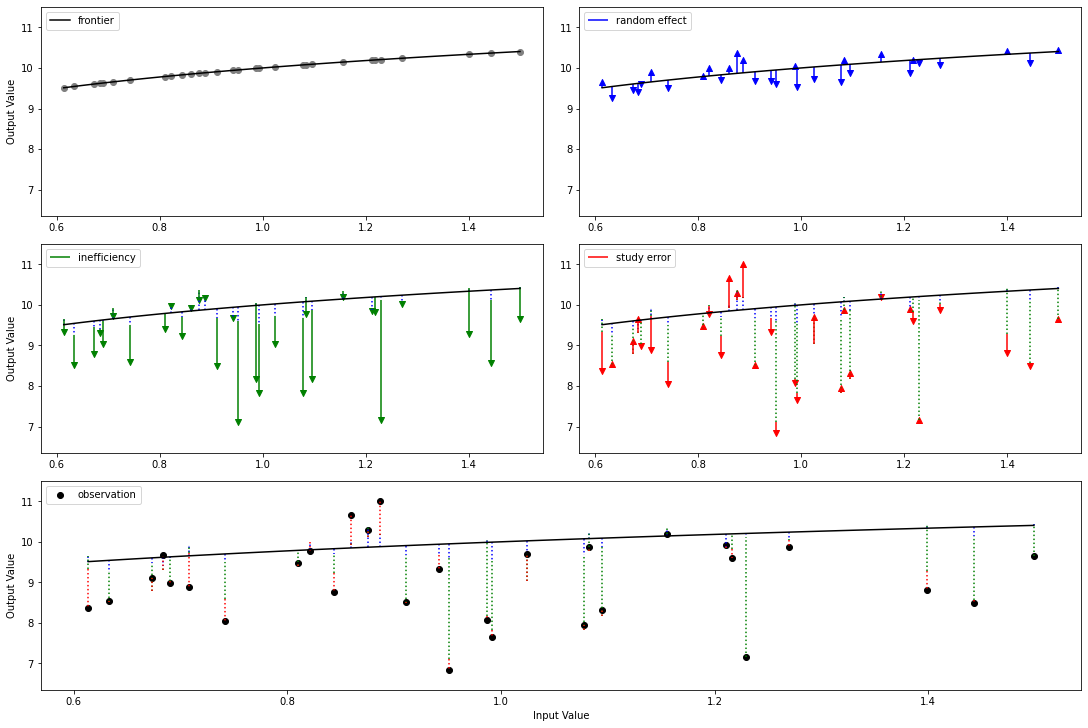

In [41]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

gs = fig.add_gridspec(3, 2)
ax0 = fig.add_subplot(gs[0, :-1])
ax1 = fig.add_subplot(gs[0, -1])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[1, -1])
ax4 = fig.add_subplot(gs[2, :])

ax0.scatter(xs, front, color='grey')
ax0.plot(x_front, y_front, color='black', label='frontier')
ax0.set_ylim([ymin, ymax])
ax0.legend(loc='upper left')
ax0.set_ylabel("Output Value")

ax1.plot(x_front, y_front, color='black')
ax1.vlines(xs, ymin=front, ymax=front+us, color='blue', label='random effect')
pos_change = us > 0
ax1.scatter(xs[pos_change], (front+us)[pos_change], color='blue', marker='^')
ax1.scatter(xs[~pos_change], (front+us)[~pos_change], color='blue', marker='v')
ax1.set_ylim([ymin, ymax])
ax1.legend(loc='upper left')

ax2.plot(x_front, y_front, color='black')
ax2.vlines(xs, ymin=front, ymax=front+us, color='blue', linestyle=':')
ax2.vlines(xs, ymin=front+us-vs, ymax=front+us, color='green', label='inefficiency')
ax2.scatter(xs, front+us-vs, color='green', marker='v')
ax2.set_ylim([ymin, ymax])
ax2.legend(loc='upper left')
ax2.set_ylabel("Output Value")

ax3.plot(x_front, y_front, color='black')
ax3.vlines(xs, ymin=front, ymax=front+us, color='blue', linestyle=':')
ax3.vlines(xs, ymin=front+us-vs, ymax=front+us, color='green', linestyle=':')
ax3.vlines(xs, ymin=front+us-vs, ymax=front+us-vs+epsilon, color='red', label="study error")
pos_change = epsilon > 0
ax3.scatter(xs[pos_change], (front+us-vs+epsilon)[pos_change], color='red', marker='^')
ax3.scatter(xs[~pos_change], (front+us-vs+epsilon)[~pos_change], color='red', marker='v')
ax3.set_ylim([ymin, ymax])
ax3.legend(loc='upper left')

ax4.scatter(xs, front+us-vs+epsilon, color='black', label='observation')
ax4.plot(x_front, y_front, color='black')
ax4.vlines(xs, ymin=front, ymax=front+us, color='blue', linestyle=':')
ax4.vlines(xs, ymin=front+us-vs, ymax=front+us, color='green', linestyle=':')
ax4.vlines(xs, ymin=front+us-vs, ymax=front+us-vs+epsilon, color='red', linestyle=':')
ax4.set_ylim([ymin, ymax])
ax4.legend(loc='upper left')
ax4.set_xlabel("Input Value")
ax4.set_ylabel("Output Value")

plt.savefig("data-generating-process.pdf")

## Figure 2

Single model fit

In [52]:
s = Simulator(nu=0.2, gamma=0.5, sigma_min=0.1, sigma_max=0.2, ineff_dist='half-normal',
              x=lambda size: stats.uniform.rvs(size=size, loc=0.0, scale=10), func=lambda x: np.log(5 * x + 1.5))
us, vs, epsilon, sigma, xs, front, observed = s.simulate(n = 500)

x_front = np.linspace(xs.min(), xs.max())
y_front = s.func(np.linspace(xs.min(), xs.max()))

In [53]:
sim = pd.DataFrame({'output': observed, 'input': xs, 'se': sigma})
sim.sort_values('input', inplace=True)

In [65]:
# Look at linear tail versus not on this one
model = SFMAModel(
    df=sim,
    col_output='output',
    col_se='se',
    col_input='input',
    #concave=True,
    include_gamma=True,
    #increasing=True
)
model.fit(options={'solver_options': {}})
preds = model.predict()
sim['predictions'] = preds

/Users/marlena/repos/SFMA/src/sfma/models/marginal.py:133: RuntimeWarning: divide by zero encountered in double_scalars
  grad[-1] += -dlerf[i] * r[i] / np.sqrt(2) * v_roe[i]**(-1/2) * 1/2 / v[i] * (np.sqrt(v[i] / v_ie[i]) - np.sqrt(v_ie[i] / v[i]))
/Users/marlena/repos/SFMA/src/sfma/models/marginal.py:133: RuntimeWarning: invalid value encountered in double_scalars
  grad[-1] += -dlerf[i] * r[i] / np.sqrt(2) * v_roe[i]**(-1/2) * 1/2 / v[i] * (np.sqrt(v[i] / v_ie[i]) - np.sqrt(v_ie[i] / v[i]))


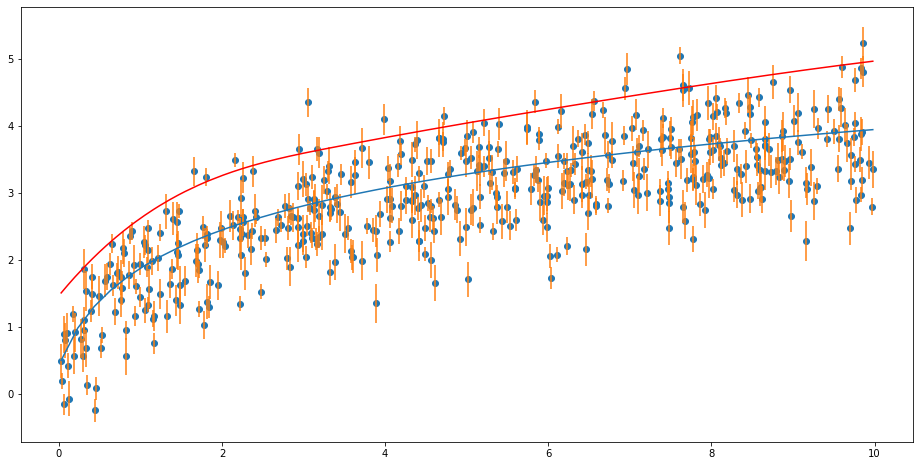

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(x_front, y_front, linestyle='solid')
ax.scatter(xs, observed)
ax.errorbar(xs, observed, yerr=sigma, linestyle='None')
ax.plot(sim['input'], sim['predictions'], c='red')

In [67]:
model.solver.result['success']

True

In [10]:
model.marginal_model.objective(data=model.data, x=increasing_opt)

NameError: name 'increasing_opt' is not defined

In [11]:
model.marginal_model.objective(data=model.data, x=model.solver.x_opt)

-0.008475344058121323

In [100]:
# increasing
increasing_opt = model.solver.x_opt

In [104]:
model.solver.result

      fun: -0.5482275477074289
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.12763219,  0.01046945, -0.2476532 , -0.28381128, -0.01359545,
        0.12359544, -2.00976747,  0.13580007])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 11
      nit: 5
     njev: 11
   status: 0
  success: True
        x: array([0.99498268, 2.3229809 , 3.00773738, 3.52905624, 4.01010908,
       4.34939444, 0.01918249, 0.12741585])

In [85]:
model.solver.x_opt

array([4.71665656e-01, 2.03433627e+00, 2.82465425e+00, 3.44184089e+00,
       3.70103612e+00, 3.74500005e+00, 6.12644203e-02, 3.14865491e-05])

In [57]:
model.marginal_model.objective(data=model.data, x=model.solver.x_opt)

0.4907236699720938

In [58]:
x_try = model.solver.x_opt
x_try[0:model.marginal_model.femat.shape[1]] -= 1.5
x_try[-1] = 0.11007753575536437

In [59]:
model.marginal_model.objective(data=model.data, x=x_try)

1.7067714460260413

In [39]:
model.solver.result

      fun: 0.593017004577358
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00055008,  0.00502864,  0.02862555,  0.03547511,  0.0133274 ,
        0.00058256,  0.10823409,  0.02343853])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 13
     njev: 18
   status: 0
  success: True
        x: array([1.87567935, 2.6627986 , 4.30358372, 4.53733314, 5.07529964,
       4.65892372, 0.        , 2.2239941 ])

In [34]:
model.solver.x_opt

array([1.87567935, 2.6627986 , 4.30358372, 4.53733314, 5.07529964,
       4.65892372, 0.        , 2.2239941 ])

Gamma

In [35]:
0.2**2

0.04000000000000001

This is what we simulated for the scale of half-normal

In [36]:
0.2

0.2

Estimated the variance of the normal, then when we did this transformation, we estimated standard deviation for the half-normal 

In [38]:
np.sqrt(1 - 2/np.pi)*np.sqrt(2.2239941)

0.8989746839100398

In [50]:
(0.2/np.sqrt(1 - 2/np.pi))**2

0.11007753575536437

## Run through many versions of simulations and try different model fits

In [158]:
def sim_fit(nu, gamma, sigma_ran):
    
    s = Simulator(nu=nu, gamma=gamma, sigma_min=sigma_ran[0], sigma_max=sigma_ran[1], ineff_dist='half-normal',
                  x=lambda size: stats.uniform.rvs(size=size, loc=0.0, scale=10), func=lambda x: np.log(5 * x + 1.5))
    us, vs, epsilon, sigma, xs, front, observed = s.simulate(n = 500)

    sim = pd.DataFrame({'output': observed, 'input': xs, 'se': sigma})
    sim.sort_values('input', inplace=True)

    x_front = np.linspace(xs.min(), xs.max())
    y_front = s.func(np.linspace(xs.min(), xs.max()))

    # Look at linear tail versus not on this one
    for concave in [True, False]:
        for increasing in [True, False]:
            for include_gamma in [True, False]:
                name = ""
                if concave:
                    name += "concave "
                if increasing:
                    name += "increasing "
                if include_gamma:
                    name += "gamma "
                if name == "":
                    name = "basic "
                model = SFMAModel(
                    df=sim,
                    col_output='output',
                    col_se='se',
                    col_input='input',
                    concave=concave,
                    include_gamma=include_gamma,
                    increasing=increasing
                )
                error = False
                try:
                    model.fit(options={'solver_options': {}})
                    converged = model.solver.result['success']
                except ValueError as e:
                    if "array must not contain infs or NaNs" in str(e):
                        error = True
                        converged = False
                    else:
                        raise e
                if converged:
                    name += "(+)"
                else:
                    if error:
                        name += "(x)"
                    else:
                        name += "(-)"
                print(name, "\r")
                if not error:
                    preds = model.predict()
                    sim[name] = preds
                else:
                    sim[name] = np.nan
    
    return sim

In [159]:
sims = dict()

j = 0
for NU in [0.01, 0.1]:
    print(f"NU {NU}")
    sims[NU] = dict()
    for GAMMA in [0.0, 0.1, 0.5]:
        print(f"GAMMA {GAMMA}")
        sims[NU][GAMMA] = dict()
        for SIGMA_RAN in [[0.01, 0.02], [0.1, 0.2]]:
            SIGMA = '-'.join([str(x) for x in SIGMA_RAN])
            print(f"SIGMA {SIGMA}")
            print(f"ITER {j}")
            this_sim = sim_fit(NU, GAMMA, SIGMA_RAN)
            sims[NU][GAMMA][SIGMA] = this_sim
            j += 1

NU 0.01
GAMMA 0.0
SIGMA 0.01-0.02
ITER 0
concave increasing gamma (+) 
concave increasing (+) 
concave gamma (+) 
concave (+) 
increasing gamma (+) 
increasing (+) 
gamma (+) 
basic (+) 
SIGMA 0.1-0.2
ITER 1


/Users/marlena/repos/SFMA/src/sfma/models/marginal.py:116: RuntimeWarning: divide by zero encountered in true_divide
  dlerf = -(1 / erfc(z)) * 2 / np.sqrt(np.pi) * np.exp(-z**2)
/Users/marlena/repos/SFMA/src/sfma/models/marginal.py:122: RuntimeWarning: invalid value encountered in multiply
  grad[0:beta.size] += -dlerf[i] * -1/np.sqrt(2) * np.sqrt(v_ie[i]) * x[i, ] / np.sqrt(v_roe[i] * v[i])


concave increasing gamma (+) 
concave increasing (+) 
concave gamma (+) 


/Users/marlena/repos/SFMA/src/sfma/models/marginal.py:116: RuntimeWarning: invalid value encountered in multiply
  dlerf = -(1 / erfc(z)) * 2 / np.sqrt(np.pi) * np.exp(-z**2)


concave (x) 
increasing gamma (+) 
increasing (+) 
gamma (+) 
basic (+) 
GAMMA 0.1
SIGMA 0.01-0.02
ITER 2


/Users/marlena/repos/SFMA/src/sfma/models/marginal.py:133: RuntimeWarning: divide by zero encountered in double_scalars
  grad[-1] += -dlerf[i] * r[i] / np.sqrt(2) * v_roe[i]**(-1/2) * 1/2 / v[i] * (np.sqrt(v[i] / v_ie[i]) - np.sqrt(v_ie[i] / v[i]))
/Users/marlena/repos/SFMA/src/sfma/models/marginal.py:133: RuntimeWarning: invalid value encountered in double_scalars
  grad[-1] += -dlerf[i] * r[i] / np.sqrt(2) * v_roe[i]**(-1/2) * 1/2 / v[i] * (np.sqrt(v[i] / v_ie[i]) - np.sqrt(v_ie[i] / v[i]))


concave increasing gamma (+) 
concave increasing (+) 
concave gamma (+) 
concave (+) 
increasing gamma (+) 
increasing (+) 
gamma (+) 
basic (+) 
SIGMA 0.1-0.2
ITER 3
concave increasing gamma (-) 
concave increasing (+) 
concave gamma (+) 
concave (+) 
increasing gamma (+) 
increasing (+) 
gamma (+) 
basic (+) 
GAMMA 0.5
SIGMA 0.01-0.02
ITER 4
concave increasing gamma (+) 
concave increasing (x) 


/Users/marlena/repos/SFMA/src/sfma/models/marginal.py:116: RuntimeWarning: overflow encountered in true_divide
  dlerf = -(1 / erfc(z)) * 2 / np.sqrt(np.pi) * np.exp(-z**2)


concave gamma (+) 
concave (x) 
increasing gamma (+) 
increasing (x) 
gamma (+) 
basic (+) 
SIGMA 0.1-0.2
ITER 5
concave increasing gamma (+) 
concave increasing (+) 
concave gamma (+) 
concave (+) 
increasing gamma (+) 
increasing (+) 
gamma (+) 
basic (+) 
NU 0.1
GAMMA 0.0
SIGMA 0.01-0.02
ITER 6
concave increasing gamma (+) 
concave increasing (+) 
concave gamma (+) 
concave (x) 
increasing gamma (+) 
increasing (+) 
gamma (+) 
basic (+) 
SIGMA 0.1-0.2
ITER 7
concave increasing gamma (+) 
concave increasing (+) 
concave gamma (+) 
concave (+) 
increasing gamma (+) 
increasing (+) 
gamma (+) 
basic (+) 
GAMMA 0.1
SIGMA 0.01-0.02
ITER 8
concave increasing gamma (+) 
concave increasing (+) 
concave gamma (+) 
concave (+) 
increasing gamma (+) 
increasing (+) 
gamma (+) 
basic (+) 
SIGMA 0.1-0.2
ITER 9
concave increasing gamma (+) 
concave increasing (+) 
concave gamma (+) 
concave (+) 
increasing gamma (+) 
increasing (+) 
gamma (+) 
basic (+) 
GAMMA 0.5
SIGMA 0.01-0.02
ITER 10
concave 

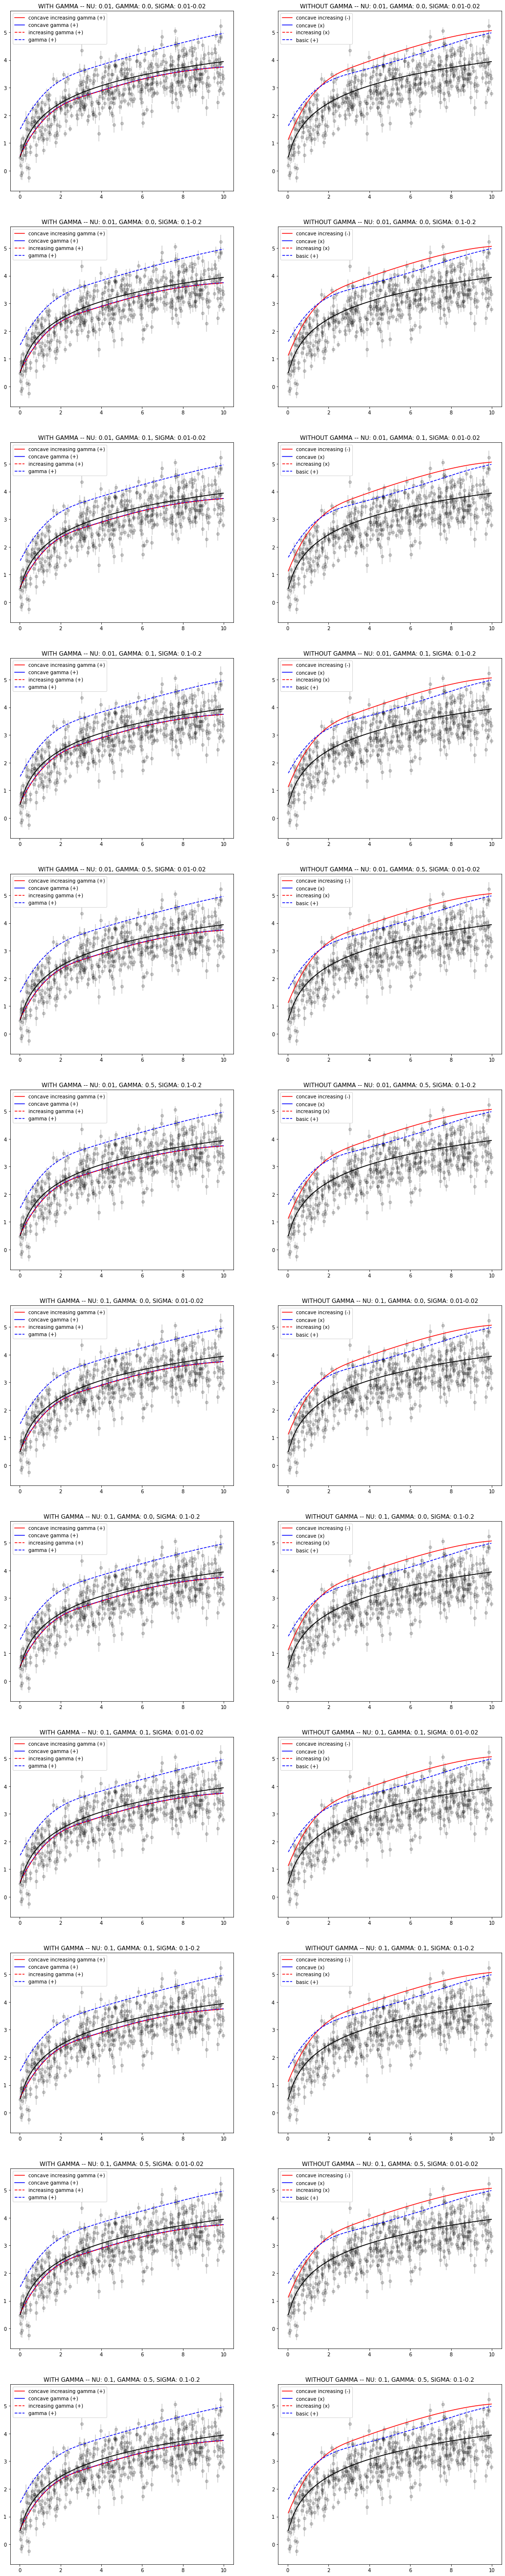

In [169]:
stys = ['solid', 'dashed']
cols = ['red', 'blue']

fig, ax = plt.subplots(12, 2, figsize=(18, 8*12))

j = 0
for NU in [0.01, 0.1]:
    for GAMMA in [0.0, 0.1, 0.5]:
        for SIGMA_RAN in [[0.01, 0.02], [0.1, 0.2]]:
            SIGMA = '-'.join([str(x) for x in SIGMA_RAN])
            this_sim = sims[NU][GAMMA][SIGMA]
            for concave in [True, False]:
                if concave:
                    sty = stys[0]
                else:
                    sty = stys[1]
                for increasing in [True, False]:
                    if increasing:
                        clr = cols[0]
                    else:
                        clr = cols[1]
                    i = 0
                    for include_gamma in [True, False]:
                        name = ""
                        if concave:
                            name += "concave "
                        if increasing:
                            name += "increasing "
                        if include_gamma:
                            name += "gamma "
                        if name == "":
                            name = "basic "
                        if name + "(+)" in sim.columns:
                            col = name + "(+)"
                        elif name + "(-)" in sim.columns:
                            col = name + "(-)"
                        elif name + "(x)" in sim.columns:
                            col = name + "(x)"

                        ax[j,i].plot(x_front, y_front, linestyle='solid', color='black', alpha=0.5)
                        ax[j,i].errorbar(xs, observed, yerr=sigma, linestyle='None', color='black', alpha=0.05)
                        ax[j,i].scatter(xs, observed, color='black', alpha=0.05)
                        ax[j,i].plot(sim['input'], sim[col], c=clr, linestyle=sty, label=col)

                        ax[j,i].legend()
                        title = f"NU: {NU}, GAMMA: {GAMMA}, SIGMA: {SIGMA}"
                        if i == 0:
                            title = "WITH GAMMA -- " + title
                        if i == 1:
                            title = "WITHOUT GAMMA -- " + title
                        ax[j,i].set_title(title)
                        i += 1
            j += 1
plt.savefig("ALL-SETTINGS.pdf")